# Constructing dataset of fire incidences and their environmental predictors

Author: Jatan Buch (v1, 231120) 


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray
import xesmf as xe # for regridding
import pickle # for saving and loading models
from pathlib import Path

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

from shapely.geometry import Point, mapping, LineString
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [26]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

## Vegetation data

In [28]:
casm_ds= xarray.open_dataset('../data/casm_for_jatan.nc') #, chunks={"date": 10}

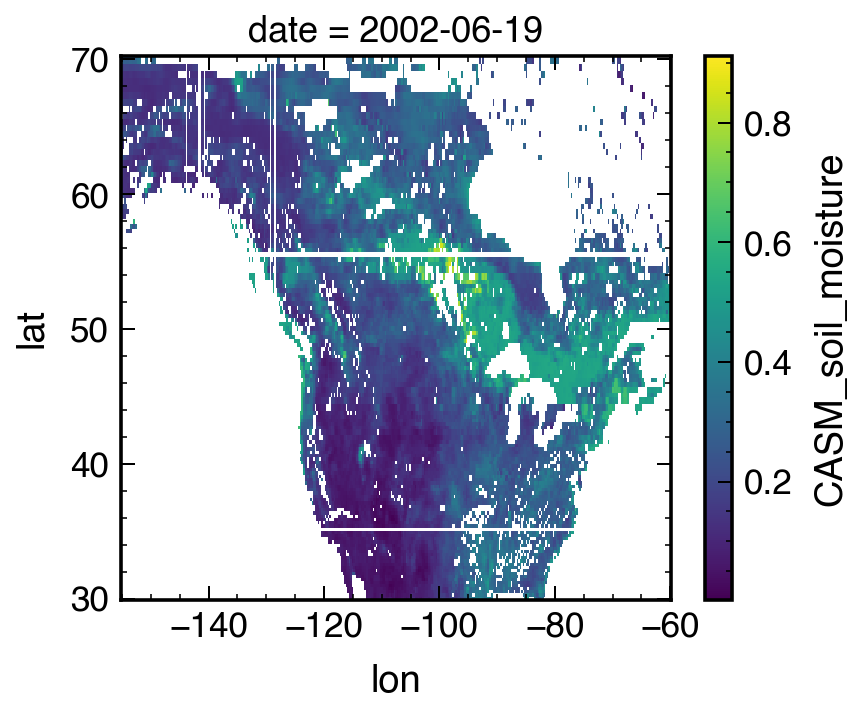

In [30]:
casm_ds.CASM_soil_moisture[0].plot()

In [7]:
casm_ds.CASM_soil_moisture

<xarray.DataArray 'CASM_soil_moisture' (date: 2210, lat: 125, lon: 350)>
dask.array<open_dataset-CASM_soil_moisture, shape=(2210, 125, 350), dtype=float64, chunksize=(10, 125, 350), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 2002-06-19 2002-06-22 ... 2020-08-31
  * lat      (lat) float64 30.07 30.29 30.52 30.75 ... 68.33 68.87 69.41 69.97
  * lon      (lon) float64 -155.0 -154.7 -154.5 -154.2 ... -60.56 -60.3 -60.04

In [31]:
csif_ds= xarray.open_dataset('../data/csif_for_jatan.nc')

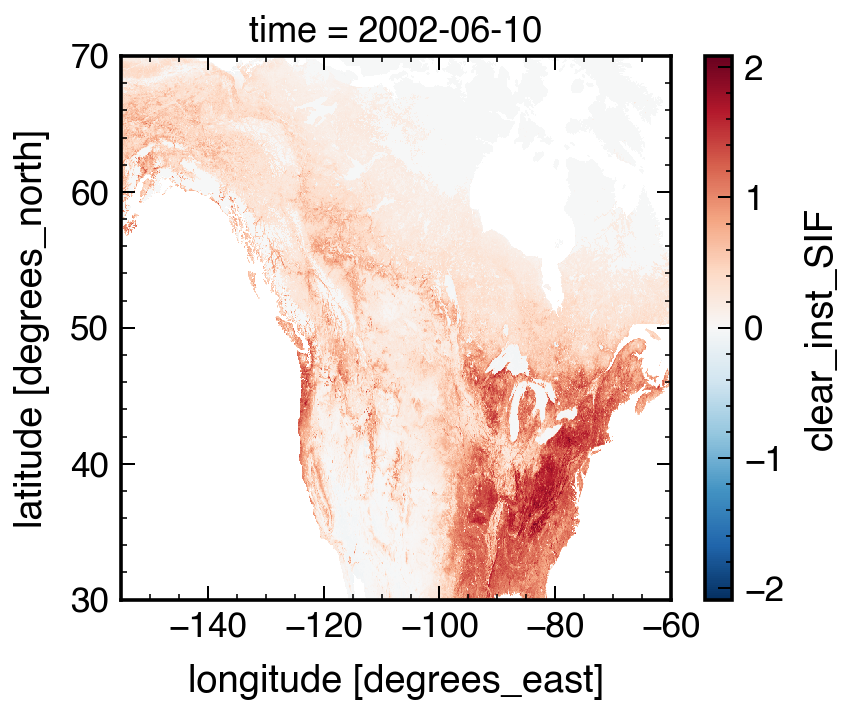

In [40]:
csif_ds.clear_inst_SIF[40].plot()

## ERA5 reanalysis data

(Used instead of gridMET for future compatability with Canadian/Australian data as well)

In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '136899:e611201e-7672-4596-9783-4fc89f7161e3'

DATADIR = '../data/meteorology'
sub = (51.6, -128, 26.5, -101) # North/West/South/East
ds_out = xarray.Dataset(
    {
        "lat": (["lat"], np.arange(26.5, 51.6, 0.125), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(-128, -101, 0.125), {"units": "degrees_west"}),
    }
)

In [64]:
var_arr= ['2m_dewpoint_temperature', '2m_temperature', 'total_precipitation'] #'10m_u_component_of_wind', '10m_v_component_of_wind',
yr_arr= list(np.arange(2002, 2021).astype(str))

### Hourly data

In [19]:
c = cdsapi.Client(url=URL, key=KEY)
for var in var_arr:
    for yr in yr_arr:
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'grib',
                'variable': [var],
                'year': [yr],
                'month': ['02', '03', '04', '05', '06', '07', '08', '09'],
                'day': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                    '13', '14', '15',
                    '16', '17', '18',
                    '19', '20', '21',
                    '22', '23', '24',
                    '25', '26', '27',
                    '28', '29', '30',
                    '31',
                ],
                'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
                'area': [51.6, -128, 26.5, -101],
            },
            f'{DATADIR}hourly/era5_wus_forecast_hourly_%s'%var + f'_%s.grib'%yr)

2023-11-21 09:23:23,456 INFO Welcome to the CDS
2023-11-21 09:23:23,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-21 09:23:23,684 INFO Request is queued
2023-11-21 09:27:43,015 INFO Request is running
2023-11-21 09:31:43,950 INFO Request is completed
2023-11-21 09:31:43,952 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.internal-1700576850.5966997-16543-1-dd2a740b-7b32-411b-a01c-670f7963d64e.grib to ../data/meteorology//era5_wus_forecast_hourly_2m_dewpoint_temperature_2020.grib (123.5M)
2023-11-21 09:32:01,091 INFO Download rate 7.2M/s  
2023-11-21 09:32:01,315 INFO Welcome to the CDS
2023-11-21 09:32:01,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-21 09:32:01,448 INFO Request is queued
2023-11-21 09:36:20,931 INFO Request is running
2023-11-21 09:38:21,409 INFO Request is completed
2023-

In [20]:
ds= xarray.open_dataset(f'{DATADIR}hourly/era5_wus_forecast_hourly_2m_temperature_2002.grib', engine='cfgrib')

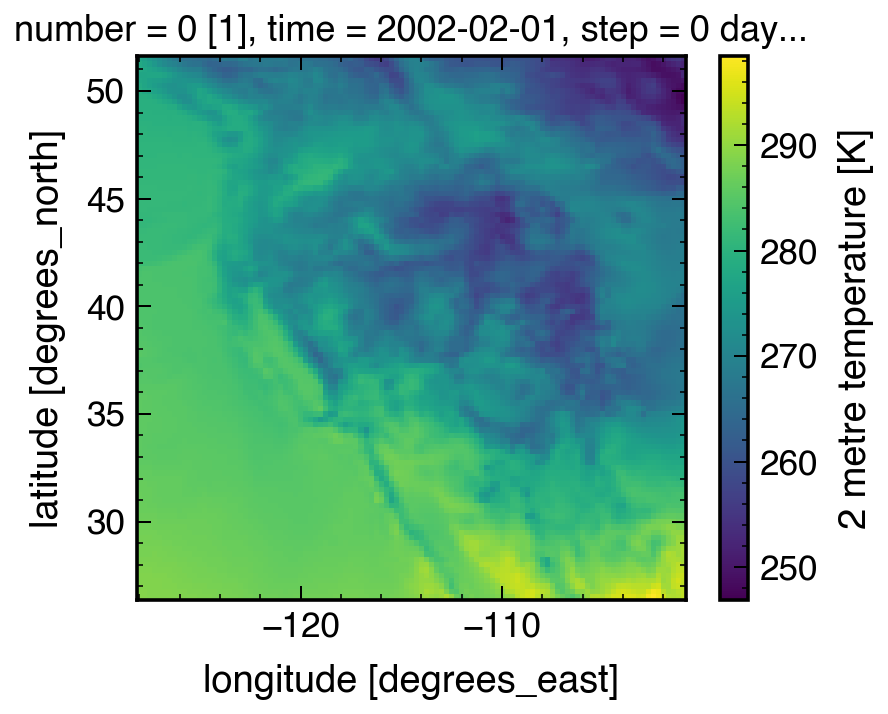

In [27]:
ds.t2m[0].plot()

### Daily data

In [174]:
def load_daily_meteorlogical_predictors(var, yrarr, datadir, maxmin_arg= None):

    '''
    Function for loading hourly meteorological predictors and saving them as a single netCDF file at daily resolution

    var: variable of interest
    yr_arr: array of years to load
    datadir: directory where data is stored
    '''
    if var == 'total_precipitation':
        const= 1000 # converting from m to mm
        var_str= 'tp'
        var_label = 'Prec'
    elif var == '2m_temperature':
        const= 273.15 # converting Kelvin to Celsius
        var_str= 't2m'
        if maxmin_arg == 'max':
            var_label = 'Tmax'
        elif maxmin_arg == 'min':
            var_label = 'Tmin'
    elif var == '2m_dewpoint_temperature':
        const= 273.15 # converting Kelvin to Celsius
        var_str= 'd2m'
        var_label= 'Tdew'    

    for yr in tqdm(yrarr):
        ds= xarray.open_dataset(f'{datadir}hourly/era5_wus_forecast_hourly_%s'%var + f'_%s.grib'%yr, engine='cfgrib')
        if var == 'total_precipitation':
            ds_prev_day= ds[var_str][:-1] # considering total rainfall from 12am to 6am
            ds_rem_day= ds[var_str][1:] # considering total rainfall from 6pm to 12am
            da= (ds.sel(time=ds['time.hour'] == 6).sum('step')[var_str] + ds_prev_day.sel(time=ds_prev_day['time.hour'] == 18, step= ds_prev_day['step'] > np.timedelta64(5, 'h')).sum('step').values + \
                                                                ds_rem_day.sel(time=ds_rem_day['time.hour'] == 18, step= ds_rem_day['step'] < np.timedelta64(6, 'h')).sum('step').values)*const
        else:
            if maxmin_arg == 'max':
                da= ds[var_str].resample(time='1D').max() - const
            elif maxmin_arg == 'min':
                da= ds[var_str].resample(time='1D').min() - const
            else:
                da= ds[var_str].resample(time='1D').mean() - const
        da.to_netcdf(f'{datadir}daily/era5_wus_forecast_daily_%s'%var_label + f'_%s.nc'%yr)
    comb_ds= xarray.open_mfdataset(f'{datadir}daily/era5_wus_forecast_daily_%s_*.nc'%var_label, parallel=True)
    comb_ds[var_str].to_netcdf(f'{datadir}daily/era5_wus_forecast_daily_%s_2002-2020.nc'%var_label)

In [93]:
load_daily_meteorlogical_predictors(var= '2m_dewpoint_temperature', yrarr= yr_arr, datadir= DATADIR)

100%|██████████| 19/19 [01:21<00:00,  4.26s/it]


In [175]:
load_daily_meteorlogical_predictors(var= 'total_precipitation', yrarr= yr_arr, datadir= DATADIR)

100%|██████████| 19/19 [00:55<00:00,  2.90s/it]
